In [1]:
#! pip install tqdm
#! pip install networkx
#! pip install transformers
#! pip install -U scikit-learn
#! pip3 install torch torchvision torchaudio
#! conda install pytorch torchvision cpuonly -c pytorch

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from tqdm import tqdm
import sys

from urllib.parse import unquote
from pathlib import Path
import networkx as nx

from transformers import AutoTokenizer, AutoModelForTokenClassification
from sklearn.metrics.pairwise import cosine_similarity
import scipy
from collections import defaultdict

from functools import partial
import torch

from urllib.parse import unquote
import pickle

In [3]:
x = torch.rand(5)
print(x)

tensor([0.6780, 0.6997, 0.6916, 0.3446, 0.7696])


In [4]:
DATA_FOLDER='./data/'
PATHS_AND_GRAPH = DATA_FOLDER + 'wikispeedia_paths-and-graph/'
PATHS_FINISHED = PATHS_AND_GRAPH + 'paths_finished.tsv'
PATHS_UNFINISHED = PATHS_AND_GRAPH + 'paths_unfinished.tsv'

In [5]:
# loading finished paths
paths_finished = pd.read_csv(PATHS_FINISHED, sep='\t', header=None, names=['hashedIpAddress', 'timestamp', 'durationInSec', 'path', 'rating'], encoding='utf-8', skiprows=16).copy(deep=True)
paths_finished["timestamp"] = pd.to_datetime(paths_finished["timestamp"], unit='s')
paths_finished.head()

,hashedIpAddress,timestamp,durationInSec,path,rating
0,6a3701d319fc3754,2011-02-15 03:26:49,166,14th_century;15th_century;16th_century;Pacific...,NaN
1,3824310e536af032,2012-08-12 06:36:52,88,14th_century;Europe;Africa;Atlantic_slave_trad...,3.0
2,415612e93584d30e,2012-10-03 21:10:40,138,14th_century;Niger;Nigeria;British_Empire;Slav...,NaN
3,64dd5cd342e3780c,2010-02-08 07:25:25,37,14th_century;Renaissance;Ancient_Greece;Greece,NaN
4,015245d773376aab,2013-04-23 15:27:08,175,14th_century;Italy;Roman_Catholic_Church;HIV;R...,3.0


In [6]:
# loading unfinished paths
paths_unfinished= pd.read_csv(PATHS_UNFINISHED, sep='\t', header=None, names=['hashedIpAddress', 'timestamp', 'durationInSec', 'path', 'target', 'type'], encoding='utf-8', skiprows=17).copy(deep=True)
paths_unfinished["timestamp"] = pd.to_datetime(paths_unfinished["timestamp"], unit='s')
paths_unfinished.head()

,hashedIpAddress,timestamp,durationInSec,path,target,type
0,2426091a53125110,2011-02-07 05:02:15,1804,Obi-Wan_Kenobi,Microsoft,timeout
1,26141fd878806294,2011-02-07 05:14:11,1805,Julius_Caesar,Caracas,timeout
2,2b015fb8181c48f2,2011-02-07 15:00:19,1818,Malawi;Democracy;Alexander_the_Great,First_Crusade,timeout
3,53a53bc244e08a6a,2011-02-07 16:06:01,49,Paraguay,Mount_St._Helens,restart
4,53a53bc244e08a6a,2011-02-07 17:18:25,1808,Paraguay;Bolivia,Mount_St._Helens,timeout


In [9]:
# Remove annoying future warnings in pandas and seaborn with new python versions
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Table of Contents
1. Metric 1: Number of backtracks per path /
2. Metric 2: \
3. Metric 3: \
4. Metric 4: \
5. Metric 5: \
6. Metric 6: \
7. Metric 7: \
8. Metric 8: \
9. Metric 9: \

# Metric 1: Number of backtracks per path

C:\Users\mathi\anaconda3\envs\ada\lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\mathi\anaconda3\envs\ada\lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


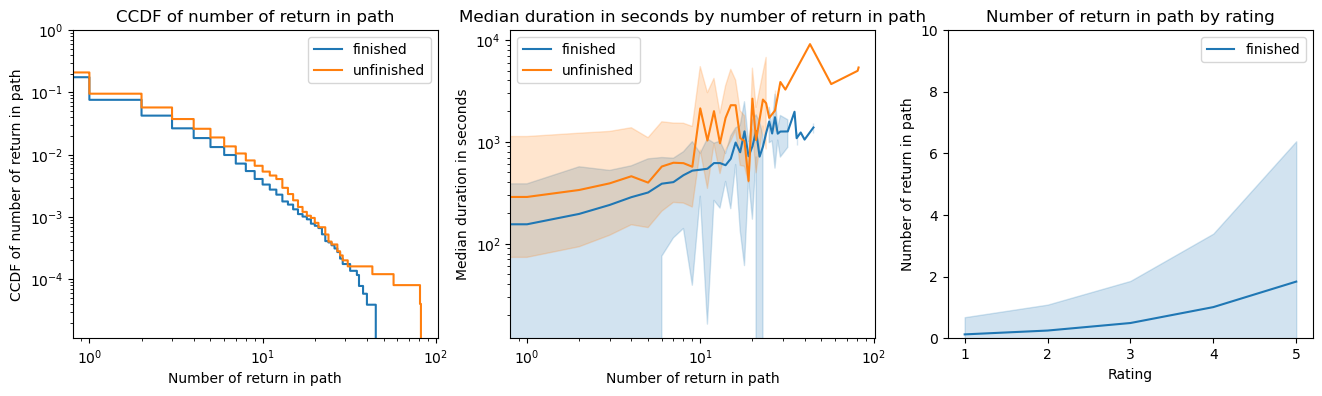

In [10]:
paths_finished["backtrack"]=paths_finished['path'].str.count('<')
paths_unfinished["backtrack"]=paths_unfinished["path"].str.count('<')
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(16, 4))
sns.ecdfplot(paths_finished["backtrack"], label='finished', ax=axs[0], complementary=True).set(xscale='log',yscale='log', ylabel='CCDF of number of return in path', xlabel='Number of return in path', title='CCDF of number of return in path')
sns.ecdfplot(paths_unfinished["backtrack"], label='unfinished', ax=axs[0], complementary=True).set(xscale='log',yscale='log', ylabel='CCDF of number of return in path', xlabel='Number of return in path')
axs[0].legend()

sns.lineplot(paths_finished,x="backtrack",y="durationInSec", ax=axs[1],label="finished",errorbar="sd",estimator="median").set(xscale="log",yscale="log", ylabel='Median duration in seconds', xlabel='Number of return in path', title='Median duration in seconds by number of return in path')
sns.lineplot(paths_unfinished,x="backtrack",y="durationInSec", ax=axs[1],label="unfinished",errorbar="sd",estimator="median").set(xscale="log",yscale="log")
axs[1].legend()

sns.lineplot(paths_finished,x="rating",y="backtrack", ax=axs[2],label="finished",errorbar="sd").set(ylim=(0,10), ylabel='Number of return in path', xlabel='Rating', title='Number of return in path by rating')
axs[2].legend()

We can see that the number of return in a path seems to follow a power law distribution and that in unfinished paths you typically have more return. Moreover there is a positive trend between the median duration of the path and the number of return in the path, as expected. Similarly, the number of return has a tendancy to be higher for paths that were considered as more complex by the player.

# Metric 2: Number of paths attempted by the player before the one played
The number of paths previously attempted by the player for each path

There are 2 ip addresses with more than 400 paths played, they will be excluded from the following plots


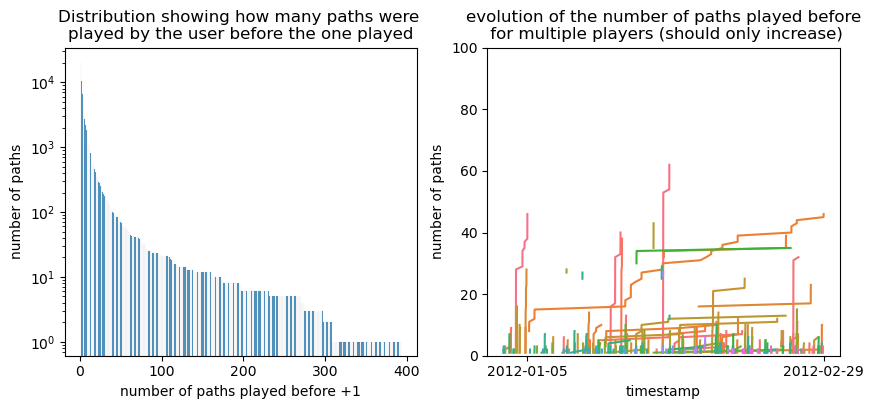

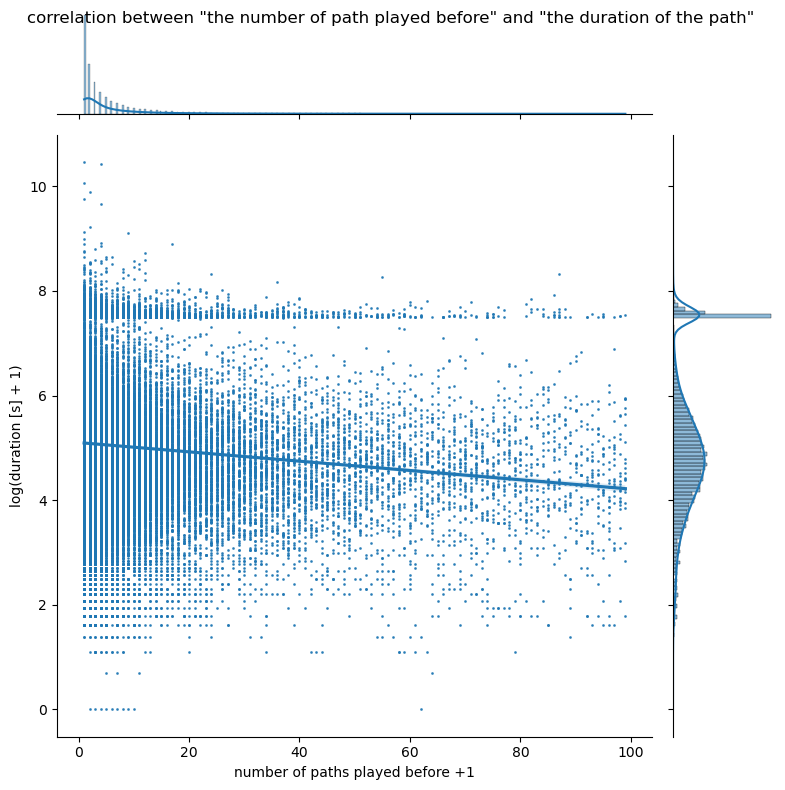

In [11]:
df_merged = pd.concat([paths_finished, paths_unfinished], ignore_index=True)
# for each row add a column with the number of path that the user has done before
#use cumcount on the groupby hashedIpAddress sorted by timestamp
df_merged['numberOfPath'] = df_merged.sort_values(by=['timestamp']).groupby('hashedIpAddress').cumcount() + 1
fig, axs = plt.subplots(figsize=(10,4), nrows=1, ncols=2)

#how many users have more than 400 paths? (2)
print("There are", len(df_merged[df_merged['numberOfPath'] == 401]["hashedIpAddress"]),"ip addresses with more than 400 paths played, they will be excluded from the following plots")
#we will exclude them for the following plots
df_merged = df_merged[~df_merged["hashedIpAddress"].isin(df_merged[df_merged['numberOfPath'] == 401]["hashedIpAddress"])]

#plot the distribution of the number of path
sns.histplot(data=df_merged, x='numberOfPath', ax=axs[0]).set(yscale='log', title='Distribution showing how many paths were \nplayed by the user before the one played', xlabel='number of paths played before +1', ylabel='number of paths')
#check that the transformation is correct by looking if the number of path is increasing in function of the timestamp
#chose a sample of hashedIpAddress (we chosed randomly a 2 months window for better visualization)
sample = df_merged.loc[(df_merged["timestamp"] > '2012-01-01 00:00:00') & (df_merged["timestamp"] < '2012-03-01 00:00:00')]
sns.lineplot(data=sample, x='timestamp', y='numberOfPath', hue='hashedIpAddress', legend=False, ax=axs[1]).set(ylim=(0, 100), xticks=[sample['timestamp'].iloc[0], sample['timestamp'].iloc[-1]], xticklabels=[sample['timestamp'].iloc[0].strftime('%Y-%m-%d'), sample['timestamp'].iloc[-1].strftime('%Y-%m-%d')], title='evolution of the number of paths played before\n for multiple players (should only increase)', xlabel='timestamp', ylabel='number of paths')

#plot correlation between number of path and duration of the path
df_merged['durationInSecLog'] = np.log(df_merged['durationInSec']+1)
sns.jointplot(data=df_merged.loc[df_merged["numberOfPath"]<100], x='numberOfPath', y='durationInSecLog', kind='reg', height=8, scatter_kws={'s':1})
plt.suptitle('correlation between "the number of path played before" and "the duration of the path"')
plt.xlabel('number of paths played before +1')
plt.ylabel('log(duration [s] + 1)')
pass #avoid printing the object

We can see that the distribution of the number of paths previously attempted by the player for each path is decreasing (as expected), that only a few players made more than 100 paths (~300) and that usually the players play only one day or few days. Finally, we can see a negative correlation between the time spent in each path and the number of paths previously attempted by the player.

# Metric 3: Graph measures
In this section we are interested in extracting graph measures from the graph. To characterize users and their paths, we will first look at some graph measures in the whole Wikipedia graph, then we will extract those measures in players paths and see how they evolve.

The goal is to assess if players go towards hubs during a game and then go to more specific pages, or if they go directly to specific pages.

First we load the shortest path matrix, then the links and the list of articles.
We use urllib.parse to unquote the links and article names.
At this stage we can already have a look at the shortest path matrix.

## Data loading

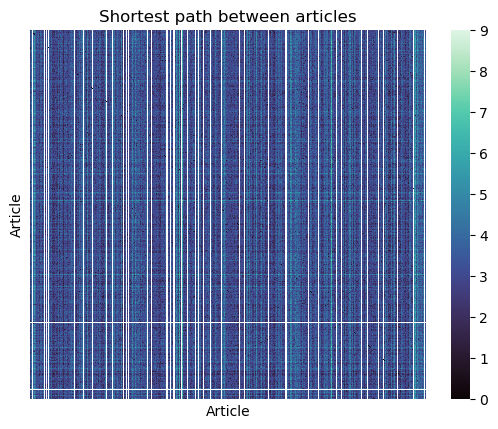

In [12]:
from graph_measures import *

shortest_path_df, links, articles = load_data_graph_metrics()
sns.heatmap(shortest_path_df, cmap="mako", xticklabels=False, yticklabels=False)
plt.title("Shortest path between articles")
plt.xlabel("Article")
plt.ylabel("Article")
plt.show()

*Note : The names are not shown for clarity.* 

We see the longest possible path is 9.



## Graph measures
Next, we compute our chosen graph measures.

We will use :
- Degree : the number of articles linked to an article (edges). A hub is expected to have a very high degree.
  An example would be the United States page, which has more than 1800 links.
- Local clustering : how strongly connected the neighbors of an article are. 
  This would be expected to be high in modules, i.e. clusters of related pages that all link to each other.
- Degree centrality : a normalized version of the degree. 
  This is the fraction of nodes a node is connected to, it might be useful as a feature since it's normalized.
- Betweenness centrality : the fraction of shortest paths that pass through a node. 
- Closeness centrality : the average length of the shortest path between a node and all other nodes.
  Both measures of centrality will be useful to define a hub, as hubs should have a higher centrality than other nodes.


We can also compute two global measures : efficiency and modularity.

- Efficiency tells us the fraction of actual connections between nodes and the total possible connections.
- Modularity is a measure of how well the graph is divided into modules, i.e. clusters of nodes that are more connected to each other than to the rest of the graph, for example articles about a specific topic.

---
***Note about local clustering:***

*While we are mostly interested in hubs in a player's path, we can use clustering to validate some of our rationale about quantifiying players characteristics.*

In [13]:
links_w_graph_metrics = compute_graph_metrics(links)
display(links_w_graph_metrics.head())

DiGraph with 4592 nodes and 119882 edges
Efficiency (pre-calculated as it takes long to compute) : 0.55814
Modularity: 5.625879039144116e-05


,from,to,degree,clustering,closeness,betweenness,degree_centrality
0,Áedán_mac_Gabráin,Bede,11,0.436364,0.0,0.0,0.002396
1,Áedán_mac_Gabráin,Columba,11,0.436364,0.0,0.0,0.002396
2,Áedán_mac_Gabráin,Dál_Riata,11,0.436364,0.0,0.0,0.002396
3,Áedán_mac_Gabráin,Great_Britain,11,0.436364,0.0,0.0,0.002396
4,Áedán_mac_Gabráin,Ireland,11,0.436364,0.0,0.0,0.002396


We see that the efficiency is slightly above 0.5, which means that more than half of the possible connections are present.
Modularity is $5 \cdot 10^{-5}$, which is very low, meaning that the graph is not well divided into modules. 

We can relate this to the distribution of the degree later, as this might indicate a scale-free graph, i.e. one where the degree distribution follows a power law.

We will now plot the distribution of the measures in the whole graph.

### Plot of graph measures for Wikipedia (subset)

C:\Users\mathi\anaconda3\envs\ada\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
C:\Users\mathi\anaconda3\envs\ada\lib\site-packages\seaborn\axisgrid.py:1609: UserWarning: KDE cannot be estimated (0 variance or perfect covariance). Pass `warn_singular=False` to disable this warning.
  func(x=x, y=y, **kwargs)
C:\Users\mathi\anaconda3\envs\ada\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


<Figure size 2000x2000 with 0 Axes>

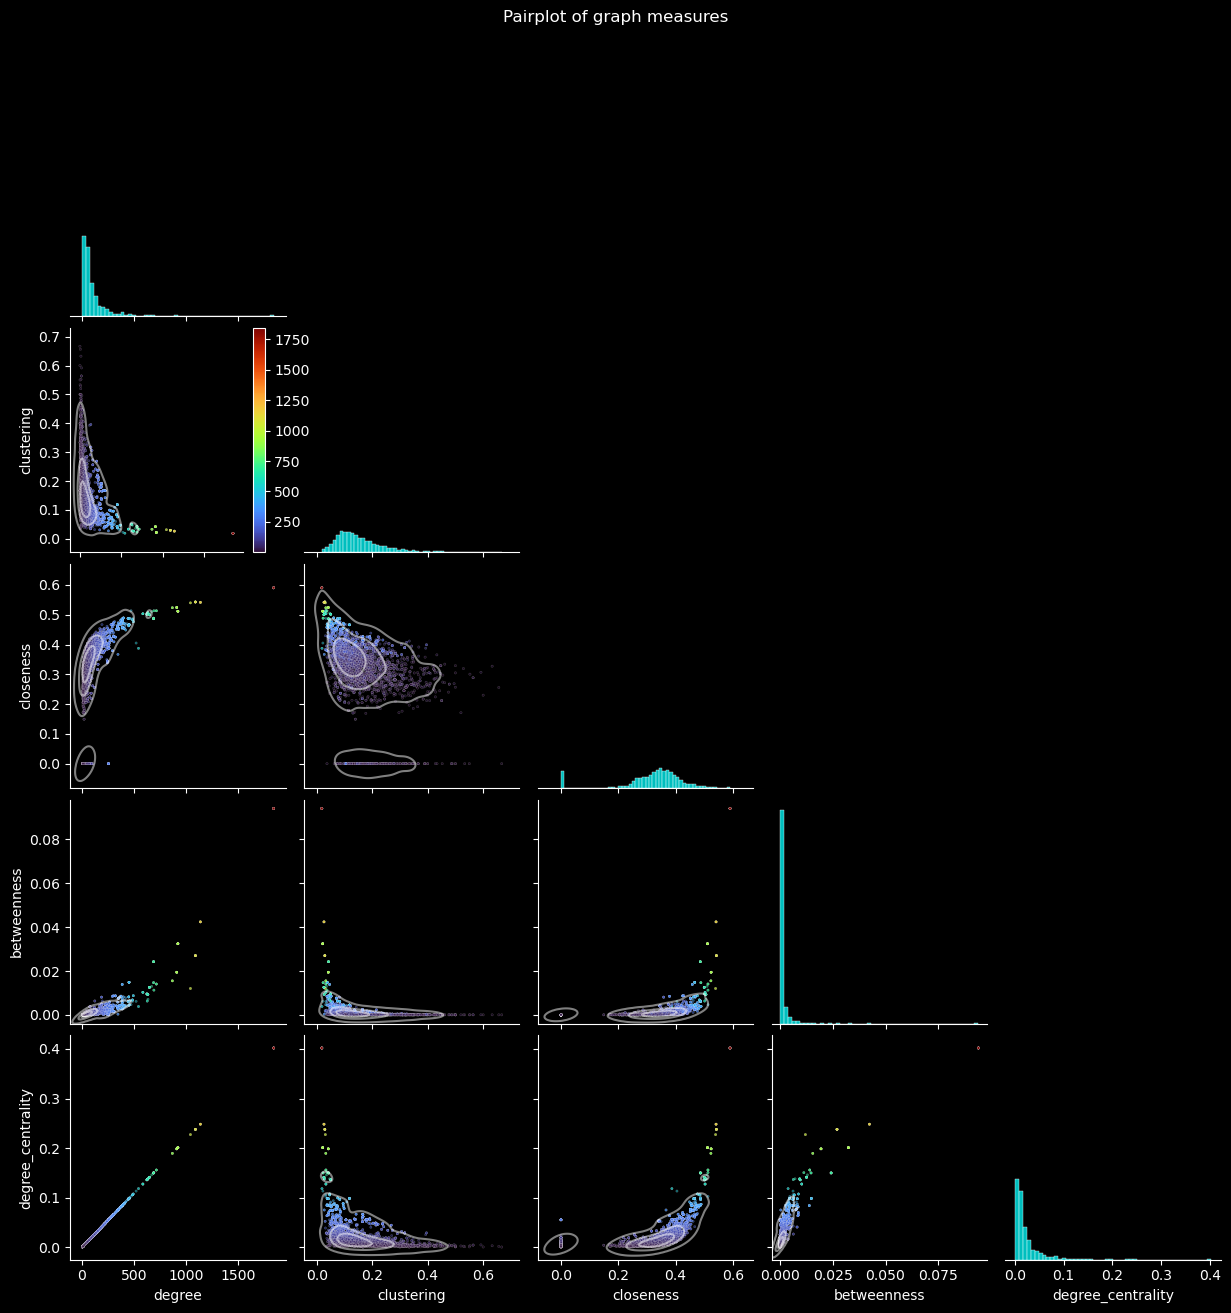

In [14]:
with plt.style.context("dark_background"):
    plt.figure(figsize=(10,10), dpi=200)

    # sample the data to avoid plotting too many points
    links_plots = links_w_graph_metrics.copy().sample(4000)

    g = sns.pairplot(links_plots[["degree", "clustering", "closeness", "betweenness", "degree_centrality"]],
                    #  kind="kde",
                    diag_kind="hist",                
                    corner=True,
                    plot_kws={"s":3, "c": links_plots["degree"], "alpha": 0.5, "cmap": "turbo"},
                    diag_kws={"bins": 50, "color": "cyan"},
                    )
    g.map_lower(sns.kdeplot, levels=4, color="white", alpha=0.5)
    g.tight_layout()
    g.fig.suptitle("Pairplot of graph measures", y=1.05)
    #### colorbar
    sm = plt.cm.ScalarMappable(cmap="turbo", norm=plt.Normalize(vmin=links_plots["degree"].min(), vmax=links_plots["degree"].max()))
    sm.set_array([])
    ax = g.fig.axes[1]
    ax.figure.colorbar(sm, ax=ax)
    ####
    plt.show()

*Note : we use a dark background here to see the colors of the scatter plots better.*
*The color of the points indicates the degree : red is higher, blue is lower.*
*The colorbar is only shown once for clarity, but is the same for all subplots.*

* We see that betweeness and degree have a very heavy-tailed distribution, with a few nodes having a very high value, and most nodes having a low value, which again is consistent with a scale-free graph. We could check the ccdf to confirm this.
* Aside from closeness-clustering, other measures seem to have an exponential relationship.

* Degree and degree centrality are obviously perfectly correlated.

## Measures per path

We will now load the user paths to apply the same measures to them.

In [15]:
paths_finished, paths_unfinished = load_and_prepare_paths_dfs_for_metrics()
display(paths_finished.head())
display(paths_unfinished.head())

,hashedIpAddress,timestamp,durationInSec,path,rating
0,6a3701d319fc3754,2011-02-15 03:26:49,166,"[14th_century, 15th_century, 16th_century, Pac...",NaN
1,3824310e536af032,2012-08-12 06:36:52,88,"[14th_century, Europe, Africa, Atlantic_slave_...",3.0
2,415612e93584d30e,2012-10-03 21:10:40,138,"[14th_century, Niger, Nigeria, British_Empire,...",NaN
3,64dd5cd342e3780c,2010-02-08 07:25:25,37,"[14th_century, Renaissance, Ancient_Greece, Gr...",NaN
4,015245d773376aab,2013-04-23 15:27:08,175,"[14th_century, Italy, Roman_Catholic_Church, H...",3.0


,hashedIpAddress,timestamp,durationInSec,path,target,type
0,2426091a53125110,2011-02-07 05:02:15,1804,[Obi-Wan_Kenobi],Microsoft,timeout
1,26141fd878806294,2011-02-07 05:14:11,1805,[Julius_Caesar],Caracas,timeout
2,2b015fb8181c48f2,2011-02-07 15:00:19,1818,"[Malawi, Democracy, Alexander_the_Great]",First_Crusade,timeout
3,53a53bc244e08a6a,2011-02-07 16:06:01,49,[Paraguay],Mount_St._Helens,restart
4,53a53bc244e08a6a,2011-02-07 17:18:25,1808,"[Paraguay, Bolivia]",Mount_St._Helens,timeout


Because our analysis relies on measures in a path with several articles, we will discard all unfinished paths with less than two articles.

In [16]:
paths_unfinished_filter = paths_unfinished.copy()
paths_unfinished_filter = paths_unfinished_filter[paths_unfinished_filter["path"].apply(len) > 2]
display(paths_unfinished_filter.head())

,hashedIpAddress,timestamp,durationInSec,path,target,type
2,2b015fb8181c48f2,2011-02-07 15:00:19,1818,"[Malawi, Democracy, Alexander_the_Great]",First_Crusade,timeout
5,131600803df4895e,2011-02-07 17:42:37,2009,"[Agriculture, History_of_the_world, China, Yan...",Grand_Canal_of_China,timeout
6,486bb79910fe9dd2,2011-02-07 18:01:00,1932,"[Mind, Christianity, Europe, Renaissance, Anci...",Scouting,timeout
7,6d136e371e42474f,2011-02-07 18:07:50,175,"[4-2-0, United_States, Agriculture, Sugar, Aus...",Cane_Toad,restart
9,6d136e371e42474f,2011-02-07 18:41:50,2006,"[Logic, Computer_science, Science, Physical_sc...",Moon_landing,timeout


## Finished paths
Here we check the distribution of those measures before and after the maximum of the path degree in finished paths.

In [17]:
path_metrics = compute_path_metrics(links=links_w_graph_metrics, paths=paths_finished)
path_metrics_around_max = get_metrics_around_max(path_metrics)

One way to see if players go towards hubs is to look at the evolution of the measures along the path before and after they reach their paths's maximal degree.
We will plot the measures before and after the degree peak, and see if there is a difference.

We also introduce a new measure : degree evolution, which is the derivative of the degree along the path. Since this is a discrete derivative, we simply subtract the degree of the previous article from the current one.

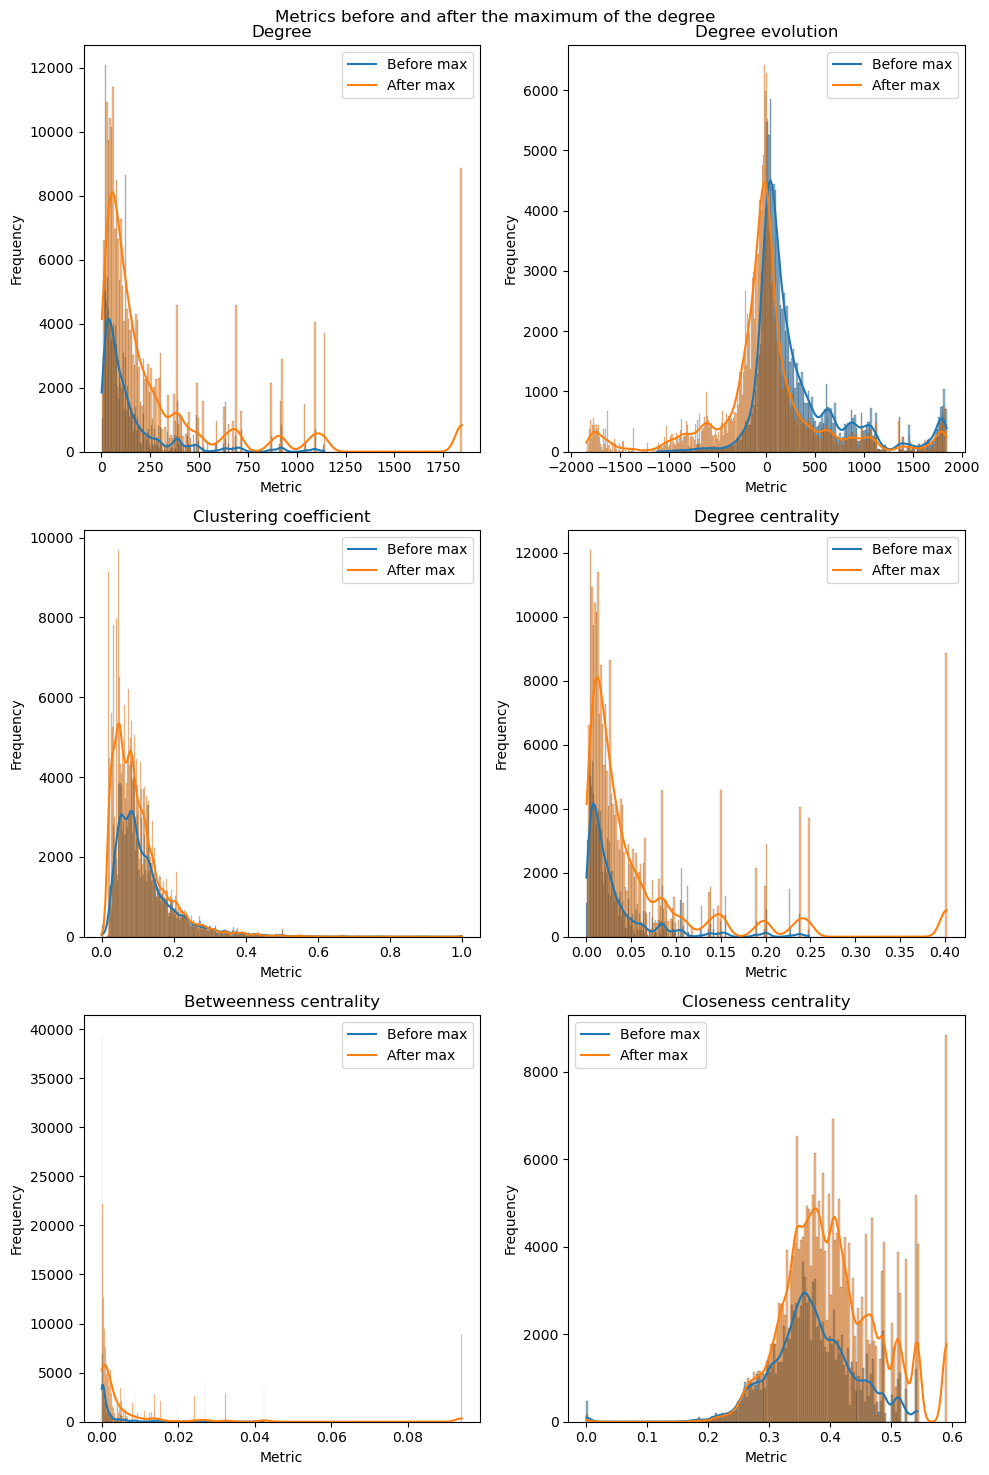

In [18]:
plot_histograms_of_metrics_before_and_after(path_metrics_around_max)

### Using slopes to assess player strategy

**From the previous plot, it is difficult to extract any differences but for the count.** We only clearly see that there are more nodes after the maximal degree and not before, which could make sense if players actively seek hubs and only then go towards the goal, but this is not so useful.

We also see in Degree evolution that the derivative has more positive values before the maximum degree, whereas after the max it has more negative values; this is more representative of a player's strategy.

Let's see if we can extract these trends more clearly by looking at a linear fit before and after the maximum degree 

(Note : in the following, **the maximum itself is not included** in the linear fit, so that we do not always have a positive then negative slope)

To clarify, we use the following functions for each metric :


In [19]:
def compute_slope(path_metric_evolution):
    """Quantifies if the slope of a metric in a path is increasing or decreasing.
    
    This is done by fitting a line to the metric and returning the slope.
    """
    idx = np.isfinite(path_metric_evolution)
    if len(path_metric_evolution[idx]) < 2: # we need at least 2 points to fit a line
        return np.nan
    fitted_line = np.polyfit(np.arange(len(path_metric_evolution))[idx], path_metric_evolution[idx], 1)
    return fitted_line[0]

def estimate_strategy(metric_array, metric=compute_slope):
    """Uses the maximum of the degree in the path to estimate the strategy of the user.
    
    The goal is to see if the degree tends to increase before reaching the maximum and then decrease.
    
    Args:
        metric_array (np.array): array of the metric for the pages in the path
        metric (function): function to use to compute the metric of the degree evolution before and after the maximum. Can use compute_slope or np.mean for example.
        
    Returns:
        m_before (float): the metric of the degree evolution before the maximum
        m_after (float): the metric of the degree evolution after the maximum
    """
    if np.isnan(metric_array).all():
        return np.nan
    max_id = np.nanargmax(metric_array)
    if max_id == 0:
        return np.nan
    elif max_id == len(metric_array) - 1:
        return np.nan
    else:
        m_before = metric(metric_array[:max_id])
        m_after = metric(metric_array[max_id-1:]) # SKIP maximum
        if m_before is np.nan or m_after is np.nan:
            return np.nan
        return m_before, m_after

Here we compute and plot the linear fits for all the measures.

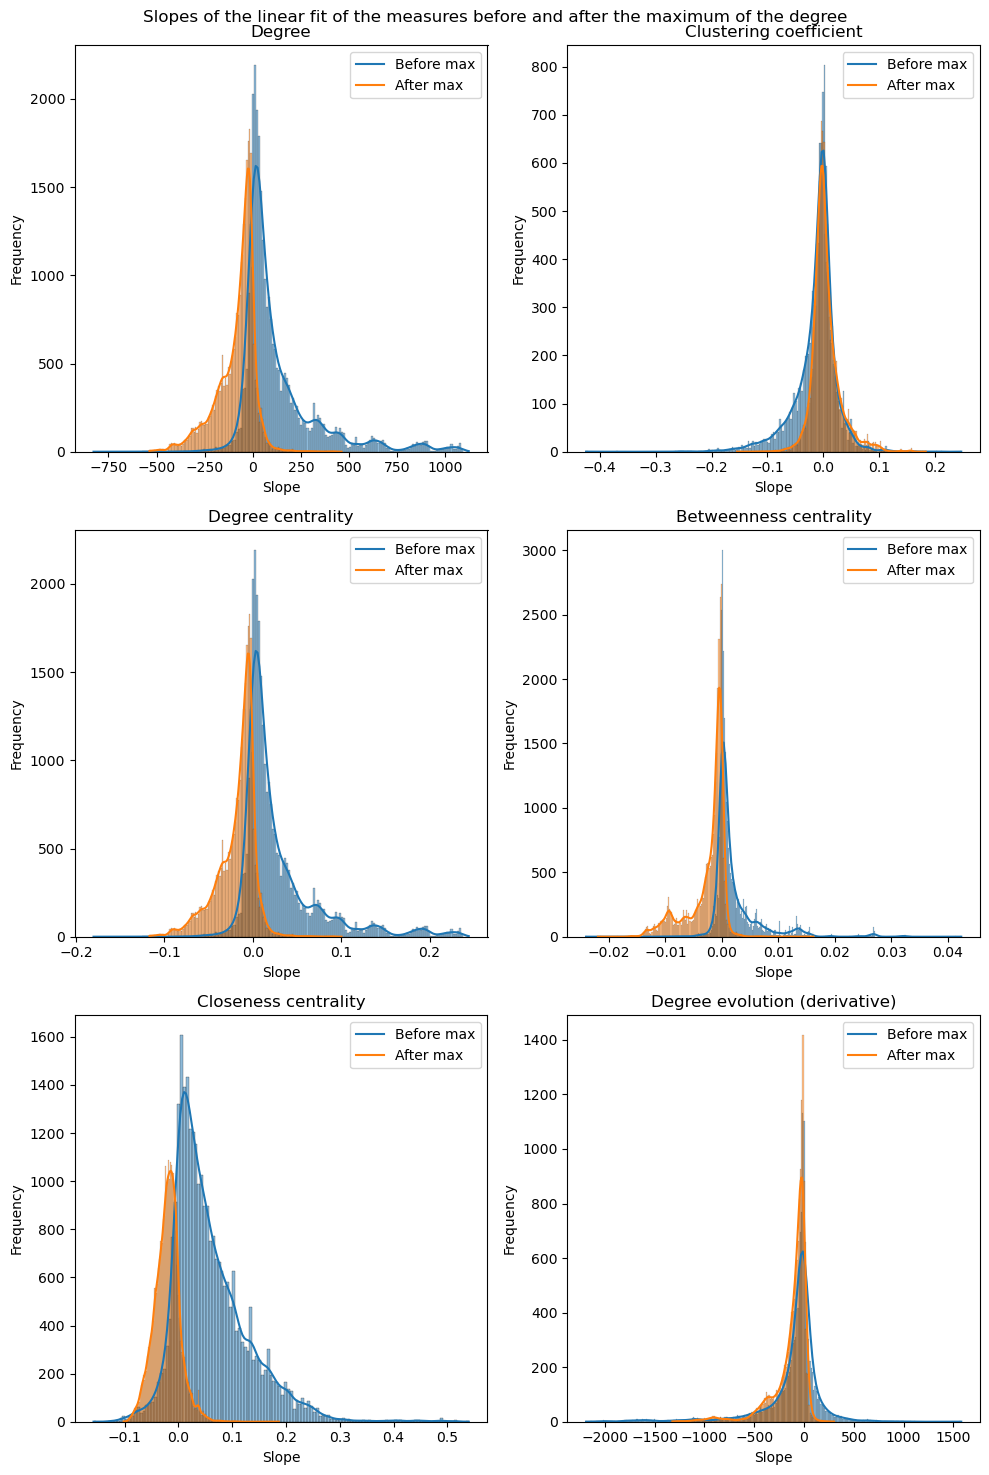

In [20]:
path_metrics["path_degree_evolution"] = path_metrics["path_degree"].map(compute_path_degree_evolution)
metrics_slopes = compute_metric_slopes(path_metrics)


fig, axs = plt.subplots(3,2, figsize=(10,15))
fig.suptitle("Slopes of the linear fit of the measures before and after the maximum of the degree")

for ax in axs.flatten():
    ax.set_xlabel("Slope")
    ax.set_ylabel("Frequency")

metric_titles = [
    "Degree",
    "Clustering coefficient",
    "Degree centrality",
    "Betweenness centrality",
    "Closeness centrality",
    "Degree evolution (derivative)"
]
 
for i, metric in enumerate(metrics_slopes):
    cur_ax = axs.flatten()[i]
    sns.histplot(data=metric, x=f"{metric.columns[0]}", ax=cur_ax, kde=True)
    sns.histplot(data=metric, x=f"{metric.columns[1]}", ax=cur_ax, kde=True)
    cur_ax.set_title(metric_titles[i])
    cur_ax.legend(["Before max", "After max"])

fig.tight_layout()
plt.show()

We see that not only are the distributions of the slope before and after fairly different, but also that the sign of the slopes tends to be more positive before and more negative after.

Only clustering coefficient and degree evolution do not show this trend, which makes sense since they are not too directly related with the "hub-likeness" of a node.

However, because of how we obtain the slopes, it could be that we have a bias towards always having a positive slope before and a negative slope after, even though we omit the maximum degree itself from the linear fit.

**Despite this, these plots are meaningful because we can see how *strongly* negative or positive a path's slope is, and we can expect that a "good" player will have, for example for degree, a more positive slope before and a more negative slope after, because they are good at quickly reaching hubs and then going to more specific pages.**

The same applies for centrality (both betweenness and closeness).

Again, degree centrality is the same as degree, but the normalization could help when comparing players.

### Unfinished paths

We can now repeat the same analysis for unfinished paths.

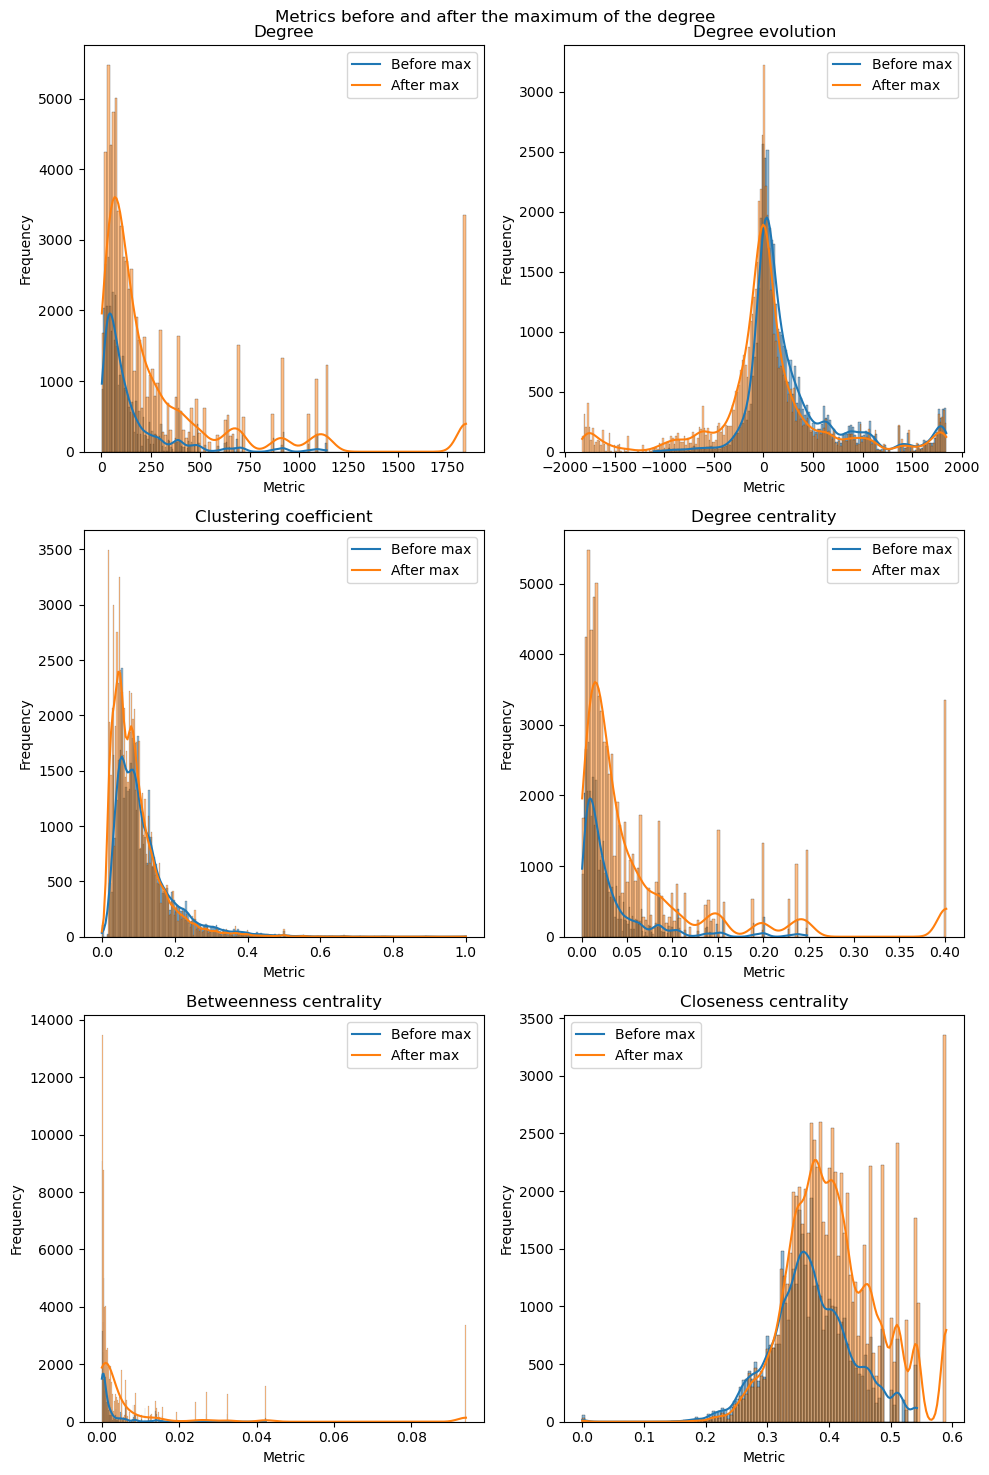

In [21]:
unfinished_path_metrics = compute_path_metrics(links=links_w_graph_metrics, paths=paths_unfinished_filter, pickle_path="./data/unfinished_path_metrics.pkl")
unfinished_path_metrics_around_max = get_metrics_around_max(unfinished_path_metrics)
plot_histograms_of_metrics_before_and_after(unfinished_path_metrics_around_max)

### Unfinished paths slopes

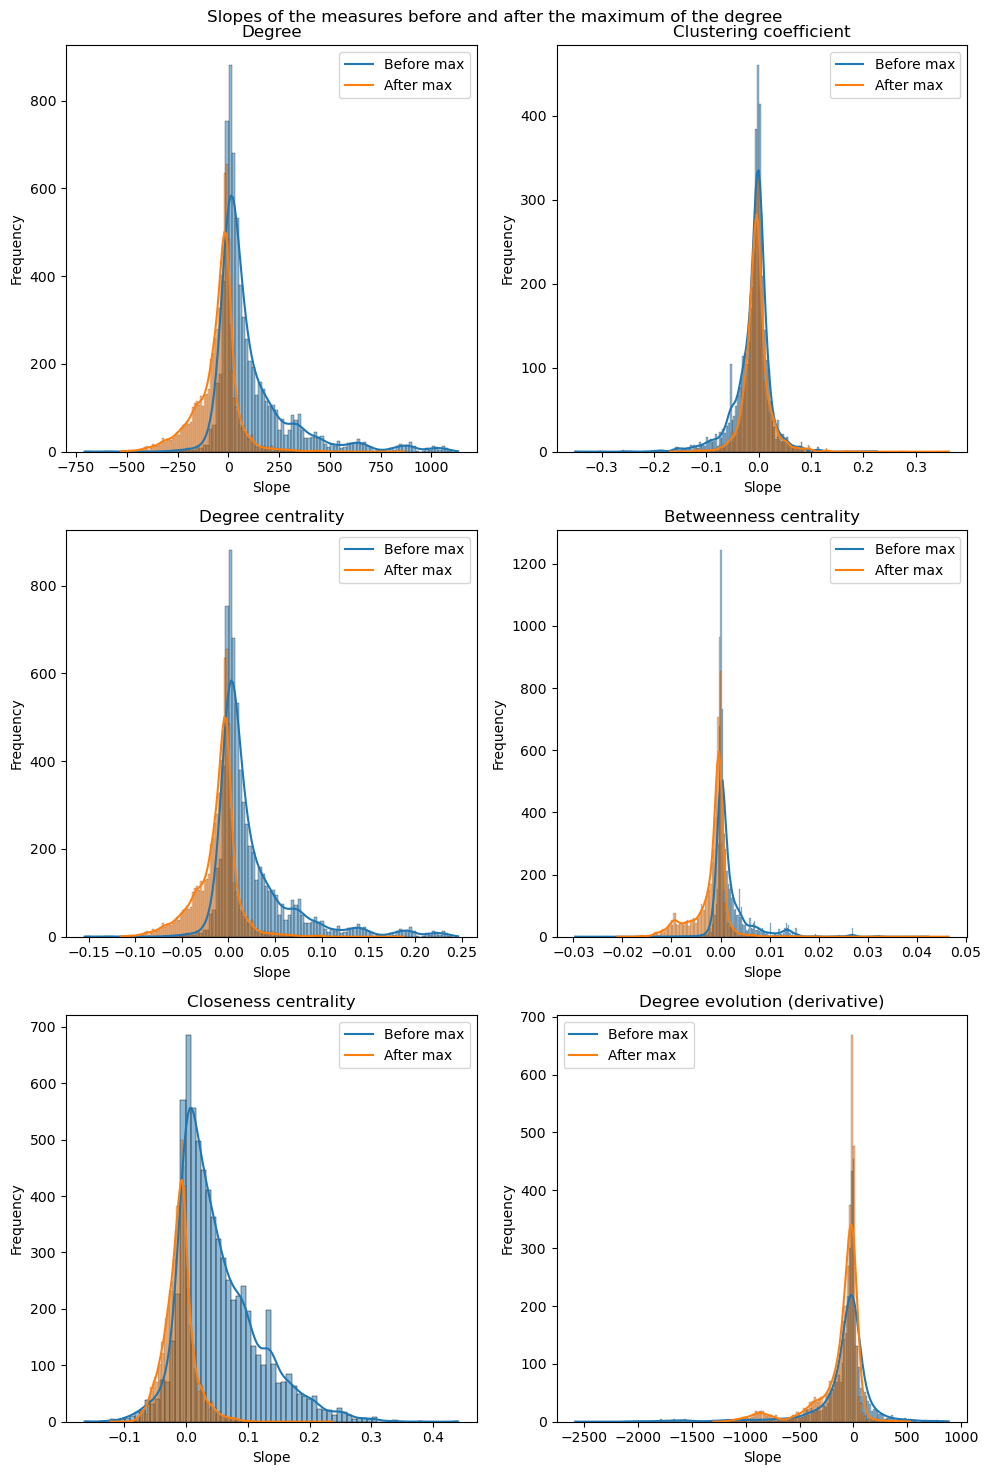

In [22]:
unfinished_path_metrics["path_degree_evolution"] = unfinished_path_metrics["path_degree"].map(compute_path_degree_evolution)
unfinished_metrics_slopes = compute_metric_slopes(unfinished_path_metrics)


fig, axs = plt.subplots(3,2, figsize=(10,15))
fig.suptitle("Slopes of the measures before and after the maximum of the degree")

for ax in axs.flatten():
    ax.set_xlabel("Slope")
    ax.set_ylabel("Frequency")

unfinished_metric_titles = [
    "Degree",
    "Clustering coefficient",
    "Degree centrality",
    "Betweenness centrality",
    "Closeness centrality",
    "Degree evolution (derivative)"
]
 
for i, metric in enumerate(unfinished_metrics_slopes):
    cur_ax = axs.flatten()[i]
    sns.histplot(data=metric, x=f"{metric.columns[0]}", ax=cur_ax, kde=True)
    sns.histplot(data=metric, x=f"{metric.columns[1]}", ax=cur_ax, kde=True)
    cur_ax.set_title(unfinished_metric_titles[i])
    cur_ax.legend(["Before max", "After max"])

fig.tight_layout()
plt.show()

# Metric 4: Player path passes by hub

# Metric 5: Player performance

# Metric 6: Position of the clicked link on the article
Find word count to link on html page for second element in successive_pairs in first elements html page

1) Removing back clicks and splitting paths...
100%|███████████████████████████████████████████████████████████████████████████| 51318/51318 [00:55<00:00, 920.15it/s]
2) Computing position for every successive pair in finished paths...
100%|██████████████████████████████████████████████████████████████████████████| 51318/51318 [00:47<00:00, 1076.72it/s]
3) Comparing whether next clicked link is under or over threshold...
Under threshold count: 94868 
Over threshold count: 77201


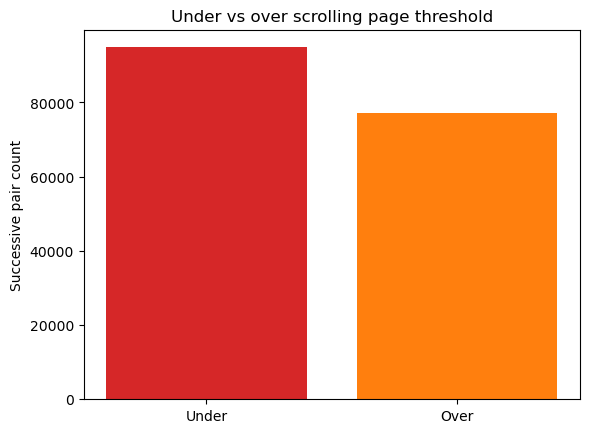

We can defenitely use this page position metric! 
The majority of players seams to not scroll to much before clicking on the next link.
4) Better metric: looking at character count before clicked link for every edge or for every player...


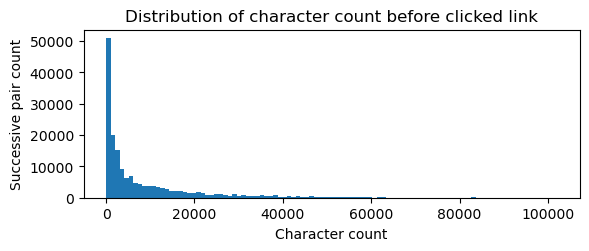

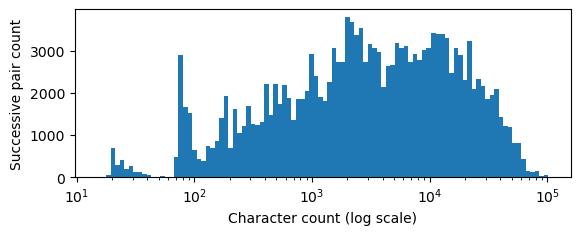

It is worth it to further investigate this metric, and see how it relates to good players. 
Also, it would be interesting to compare this metric in finished and unfinised games.


In [24]:
# runtime = ~1min30
paths_finished = pd.read_csv(PATHS_FINISHED, sep='\t', header=None, names=['hashedIpAddress', 'timestamp', 'durationInSec', 'path', 'rating'], encoding='utf-8', skiprows=16).copy(deep=True)
paths_finished["timestamp"] = pd.to_datetime(paths_finished["timestamp"], unit='s')
paths_finished_copy = paths_finished.copy(deep = True)
pd.options.mode.chained_assignment = None # to remove warning

# Removing back clicks (<) and splitting paths
print('1) Removing back clicks and splitting paths...')
for i in tqdm(range(len(paths_finished_copy)),file=sys.stdout):
    paths_finished_copy['path'].iloc[i] = paths_finished_copy['path'].iloc[i].split(';')
    for item in paths_finished_copy['path'].iloc[i].copy():
        if (item == '<'):
            paths_finished_copy['path'].iloc[i].remove(item)

# Grouping successive pairs 
successive_pairs = [[(x[i], x[i+1]) for i in range(len(x) - 1)] for x in paths_finished_copy['path'].to_list()]

# Function that returns path to plaintext article
def path_to_plaintext(article_name):
    article_name_undsc = article_name.replace(" ", "_")
    ALL_PLAINTEXT = "./data/plaintext_articles/"
    path = ALL_PLAINTEXT + article_name_undsc + ".txt"
    return path 

# Function returning character count before clicked link of a sucessive pair (that is, position of second word in seccessive pair in first word in pair's article)
def find_word_position(successive_pair):
    target_words = successive_pair[1].replace("_", " ")
    article = path_to_plaintext(successive_pair[0])
    
    with open(article,encoding = "utf8") as file:
        content = file.read()
        try:
            return content.index(target_words)
        except: # Mistake because sometimes word in is html file but not in text file. To be treated later.
            #print(f"The group of words '{successive_pair[1]}' was not found in the file '{successive_pair[0]}'.") 
            return 0

# Computing maximum path length
path_length = paths_finished_copy['path'].apply(lambda x: len(x))
max_path_length = path_length.max()


# Compute position for every pair in finished paths
print('2) Computing position for every successive pair in finished paths...')
positions_of_next_clicked_link = np.zeros((len(successive_pairs), max_path_length - 1))
for i in tqdm(range(len(successive_pairs)),file=sys.stdout):
    for j in range(len(successive_pairs[i])):
        positions_of_next_clicked_link[i,j] = find_word_position(successive_pairs[i][j])

# Computing average position of next clicked link
average_position = positions_of_next_clicked_link[np.nonzero(positions_of_next_clicked_link)].mean()


# Compare whether next clicked link is under or over threshold
print('3) Comparing whether next clicked link is under or over threshold...')
# Assuming a threshold of character count before word position
threshold = 4000  # try different ones maybe
under_threshold = np.count_nonzero(positions_of_next_clicked_link[np.nonzero(positions_of_next_clicked_link)] < threshold)
over_threshold = np.count_nonzero(positions_of_next_clicked_link[np.nonzero(positions_of_next_clicked_link)] > threshold)
print('Under threshold count:', under_threshold, '\nOver threshold count:', over_threshold)

groups = ['Under', 'Over']
counts = [under_threshold, over_threshold]
bar_colors = ['tab:red', 'tab:orange']
plt.bar(groups, counts, color=bar_colors)
plt.ylabel('Successive pair count')  # maybe aglomerate by players, not leave by successive pair count
plt.title('Under vs over scrolling page threshold')
plt.show()

print('We can defenitely use this page position metric! \nThe majority of players seams to not scroll to much before clicking on the next link.')


# Maybe a better metric: simply looking at the character count before clicked link 
print('4) Better metric: looking at character count before clicked link for every edge or for every player...')

# Histogram on linear scale
plt.subplot(211)
hist, bins, _ = plt.hist(positions_of_next_clicked_link[np.nonzero(positions_of_next_clicked_link)], bins = 100)
plt.title('Distribution of character count before clicked link')
plt.xlabel('Character count')
plt.ylabel('Successive pair count')
plt.show()

# Histogram on log scale
logbins = np.logspace(np.log10(bins[0]),np.log10(bins[-1]),len(bins)) # Use non-equal bin sizes, such that they look equal on log scale.
plt.subplot(212)
plt.hist(positions_of_next_clicked_link[np.nonzero(positions_of_next_clicked_link)],bins=logbins)
plt.xscale('log')
plt.xlabel('Character count (log scale)')
plt.ylabel('Successive pair count')
plt.show()

print('It is worth it to further investigate this metric, and see how it relates to good players. \nAlso, it would be interesting to compare this metric in finished and unfinised games.')

# Metric 7: Path length
Are longer paths more challenging? Do they lead to giving up?
(Look at path length, ratings and giving up rate)

### Additional datasets needed for Path Length metric

In [26]:
# Loading shortest path distance matrix 
SHORTEST_PATH_MATRIX = PATHS_AND_GRAPH + 'shortest-path-distance-matrix.txt'
shortest_path_distance_matrix= pd.read_csv(SHORTEST_PATH_MATRIX, sep='\t', names=['shortest path'], header=None, encoding='utf-8', skiprows=17).copy(deep=True)
shortest_path_distance_matrix = shortest_path_distance_matrix['shortest path'].apply(lambda x: list(x)) # splitting string into list
display(shortest_path_distance_matrix.head())

0    [0, _, _, _, _, _, 3, 3, 3, 3, 3, 3, 2, 5, 6, ...
1    [_, 0, _, _, _, _, 2, 2, 2, 2, 2, 3, 2, 5, 6, ...
2    [_, _, 0, _, _, _, 3, 3, 2, 2, 2, 4, 2, 5, 6, ...
3    [_, _, _, 0, _, _, 3, 3, 3, 3, 3, 3, 2, 5, 6, ...
4    [_, _, _, _, 0, _, 2, 2, 3, 2, 3, 3, 3, 5, 6, ...
Name: shortest path, dtype: object

In [27]:
# loading articles dataset
ARTICLES = PATHS_AND_GRAPH + 'articles.tsv'
articles= pd.read_csv(ARTICLES, sep='\t', header=None, encoding='utf-8', names=['article name'], skiprows=12).copy(deep=True)
display(articles.head())

,article name
0,%C3%81ed%C3%A1n_mac_Gabr%C3%A1in
1,%C3%85land
2,%C3%89douard_Manet
3,%C3%89ire
4,%C3%93engus_I_of_the_Picts


1) Removing mistakes from target column...
2) Removing back clicks and splitting paths...
100%|██████████████████████████████████████████████████████████████████████████| 51318/51318 [00:47<00:00, 1089.79it/s]
3) Computing optimal finished path length...
100%|██████████████████████████████████████████████████████████████████████████| 51318/51318 [00:50<00:00, 1012.13it/s]
Mean optimal path length for finished games: 2.85
4) Computing optimal unfinished path length...
100%|███████████████████████████████████████████████████████████████████████████| 24846/24846 [00:29<00:00, 849.89it/s]
Mean optimal path length for unfinished games: 3.23
A longer optimal path length might cause more restarts and timouts, this is a metric we can further explore!
5) Plotting rating and finished path length...


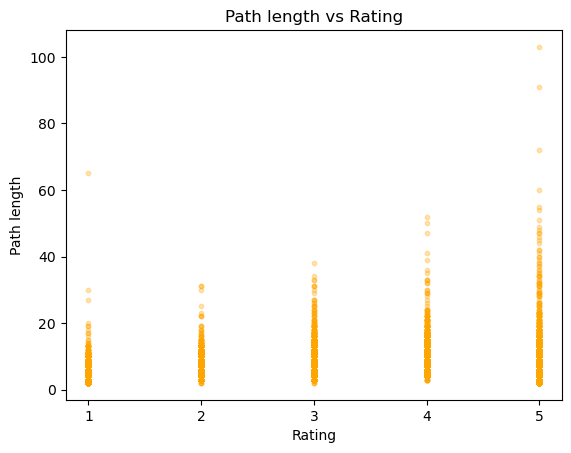

There seems to be a positive correlation between path length and rating. 
This is a metric we can potentially use after further testing and investigation.


In [28]:
# runtime = ~2min30sec
paths_finished = pd.read_csv(PATHS_FINISHED, sep='\t', header=None, names=['hashedIpAddress', 'timestamp', 'durationInSec', 'path', 'rating'], encoding='utf-8', skiprows=16).copy(deep=True)
paths_finished["timestamp"] = pd.to_datetime(paths_finished["timestamp"], unit='s')
paths_unfinished= pd.read_csv(PATHS_UNFINISHED, sep='\t', header=None, names=['hashedIpAddress', 'timestamp', 'durationInSec', 'path', 'target', 'type'], encoding='utf-8', skiprows=17).copy(deep=True)
paths_unfinished["timestamp"] = pd.to_datetime(paths_unfinished["timestamp"], unit='s')

paths_finished_copy = paths_finished.copy(deep = True)
paths_unfinished_copy = paths_unfinished.copy(deep = True)
pd.options.mode.chained_assignment = None # to remove warning

# Delete datapoints from 'paths_unfinished_copy' if 'target' isn't part of article list from 'articles' dataframe
print('1) Removing mistakes from target column...')
paths_unfinished_copy = paths_unfinished_copy[paths_unfinished_copy['target'].isin(articles['article name'])]

# Removing back clicks (<) and splitting paths
print('2) Removing back clicks and splitting paths...')
for i in tqdm(range(len(paths_finished_copy)),file=sys.stdout):
    paths_finished_copy['path'].iloc[i] = paths_finished_copy['path'].iloc[i].split(';')
    for item in paths_finished_copy['path'].iloc[i].copy():
        if (item == '<'):
            paths_finished_copy['path'].iloc[i].remove(item)


## Comparing optimal path length between finished and unfinished

# function computing optimal path length
def mean_optimal_path_length(paths, finished, shortest_path_distance_matrix):
    mean = np.zeros((len(paths),1))
    for i in tqdm(range(len(mean)),file=sys.stdout):
        if finished == True:
            start_article = paths['path'][i][0]
            end_article = paths['path'][i][-1]
        else:
            start_article = paths['path'].iloc[i].split(';')[0]
            end_article = paths['target'].iloc[i]
        start_index = articles[articles['article name'] == start_article].index[0]
        end_index = articles[articles['article name'] == end_article].index[0]
        if shortest_path_distance_matrix[start_index][end_index] == '_' :
            mean[i] = -1                     # 'long peper' error !!!
        else:
            mean[i] = shortest_path_distance_matrix[start_index][end_index]
    return mean.mean()

print('3) Computing optimal finished path length...')
mean_finished_optimal_path_length = mean_optimal_path_length(paths_finished_copy, True, shortest_path_distance_matrix) # change to only take unique path datapoints !!!
print('Mean optimal path length for finished games:', "%.2f" %mean_finished_optimal_path_length)

print('4) Computing optimal unfinished path length...')
mean_unfinished_optimal_path_length = mean_optimal_path_length(paths_unfinished_copy, False, shortest_path_distance_matrix) 
print('Mean optimal path length for unfinished games:', "%.2f" %mean_unfinished_optimal_path_length)
print('A longer optimal path length might cause more restarts and timouts, this is a metric we can further explore!')

# Exploring possible correlation between rating and finished path length 
print('5) Plotting rating and finished path length...')
paths_finished_copy_woNan = paths_finished_copy.dropna(subset=["rating"]) # Remove nans from the 'rating' columns
paths_finished_copy_woNan = paths_finished_copy_woNan[paths_finished_copy_woNan['path'].apply(lambda x: len(x) <= 200)] # Remove aberrant path length value

plt.scatter(paths_finished_copy_woNan['rating'], paths_finished_copy_woNan['path'].apply(lambda x: len(x)), alpha = 0.3, s = 10, color = 'orange')
plt.ylabel('Path length')
plt.xlabel('Rating')
plt.xticks(ticks=[1,2,3,4,5])
plt.title('Path length vs Rating')
plt.show()

print('There seems to be a positive correlation between path length and rating. \nThis is a metric we can potentially use after further testing and investigation.')

# Metric 7: Path length
## LAURENT
Do longer paths lead to the player giving up?\
Can we make some sort of extrapolation from this data?

54 paths given up on in common with finished


C:\Users\mathi\anaconda3\envs\ada\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
C:\Users\mathi\AppData\Local\Temp\ipykernel_29108\2993376345.py:19: UserWarning: The figure layout has changed to tight
  p1.figure.tight_layout()


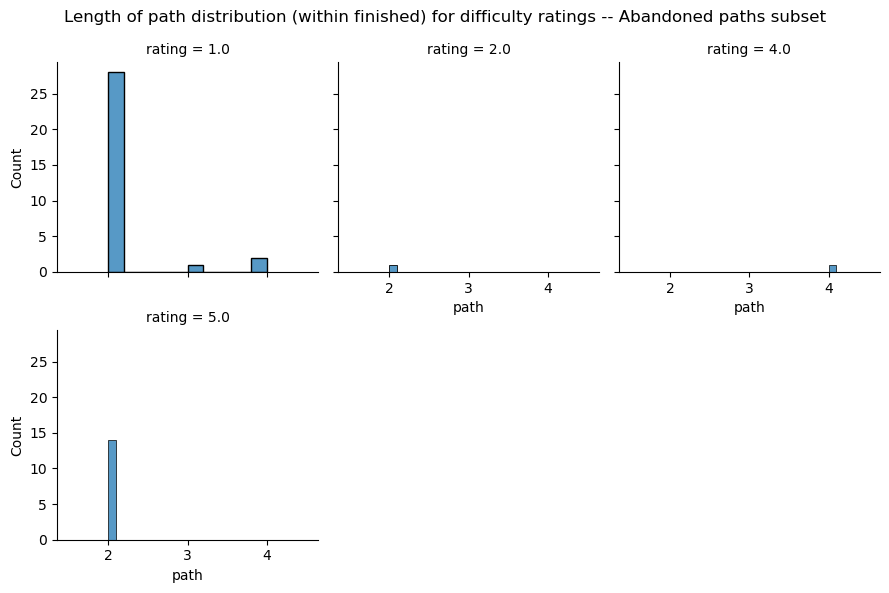

C:\Users\mathi\anaconda3\envs\ada\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
C:\Users\mathi\AppData\Local\Temp\ipykernel_29108\2993376345.py:31: UserWarning: The figure layout has changed to tight
  p2.figure.tight_layout()


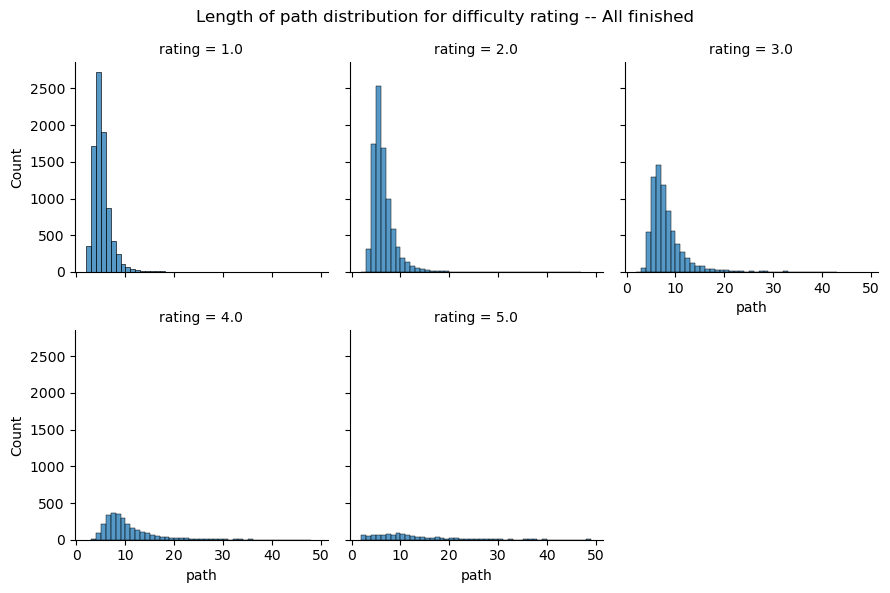

In [29]:
paths_finished_set = set(paths_finished['path']) # Get finished paths
given_up_paths = set(paths_unfinished['path']) # Get unfinished paths

# These are both sets of strings

common_paths = paths_finished_set.intersection(given_up_paths)
print(len(common_paths), 'paths given up on in common with finished')

common_path_idx = np.concatenate([np.where(paths_finished['path'] == x)[0] for x in common_paths])


paths_and_len_common = paths_finished.iloc[common_path_idx][['path', 'rating']].copy()
paths_and_len_common['path'] = paths_and_len_common['path'].apply(lambda x: len(x.split(';')))


p1 = sns.FacetGrid(paths_and_len_common, col='rating', col_wrap=3)
p1.map_dataframe(sns.histplot, data = paths_and_len_common, x='path', bins=10)
p1.figure.suptitle('Length of path distribution (within finished) for difficulty ratings -- Abandoned paths subset')
p1.figure.tight_layout()
plt.show()

paths_and_len_all = paths_finished[['path', 'rating']].copy()
paths_and_len_all['path'] = paths_and_len_all['path'].apply(lambda x: len(x.split(';')))

paths_and_len_all = paths_and_len_all.sort_values(by='path')
paths_and_len_all = paths_and_len_all[:-50]

p2 = sns.FacetGrid(paths_and_len_all, col='rating', col_wrap=3)
p2.map_dataframe(sns.histplot, data = paths_and_len_all, x='path', binwidth=1)
p2.figure.suptitle('Length of path distribution for difficulty rating -- All finished')
p2.figure.tight_layout()
plt.show()

# Metric 8: Distribution of average time per edge  
## DAVID

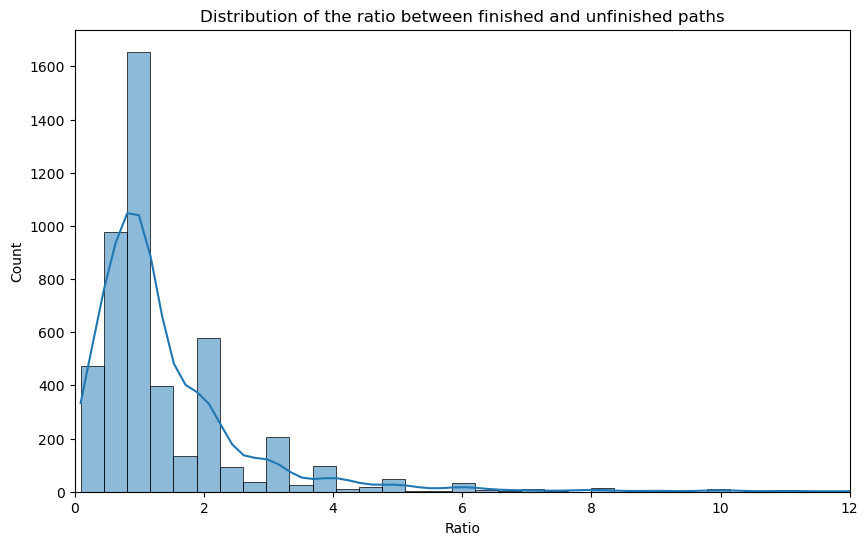

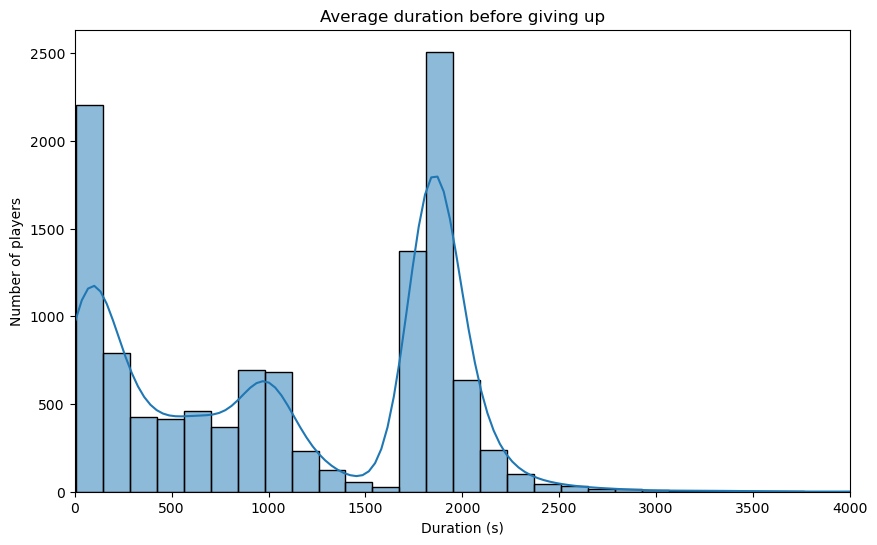

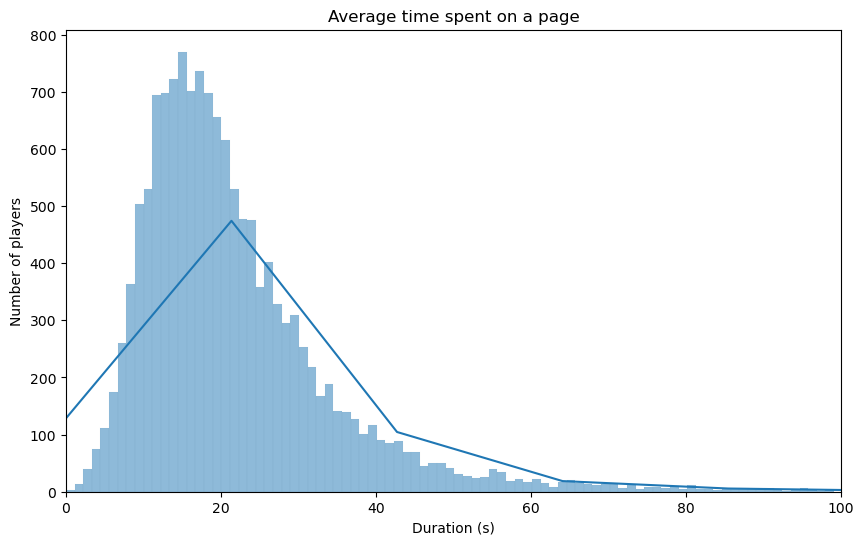

<Figure size 1000x600 with 0 Axes>

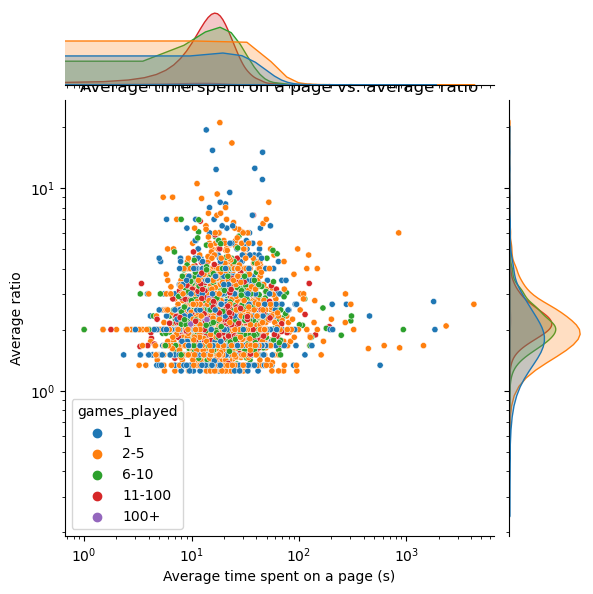

<Figure size 1000x600 with 0 Axes>

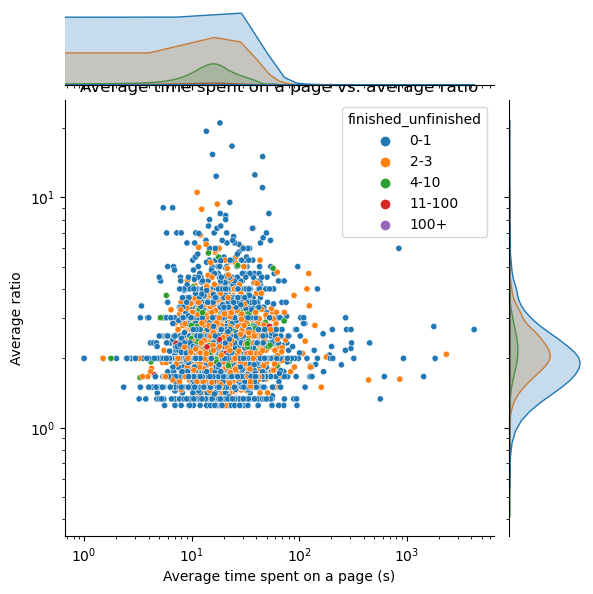

<Figure size 1000x600 with 0 Axes>

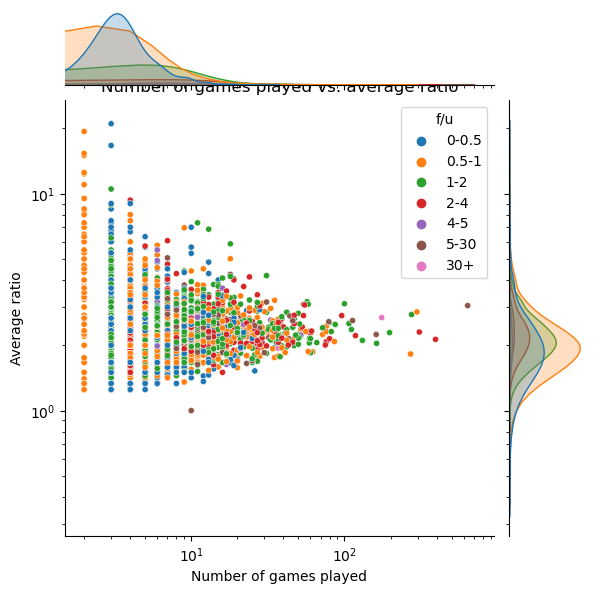

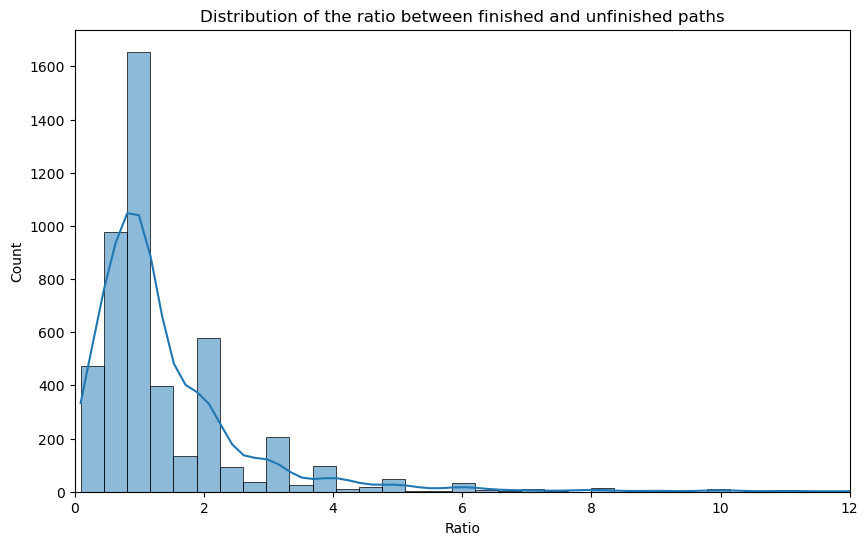

In [30]:
### Loading the data ###
DATA_PATH = Path.cwd() / "data/wikispeedia_paths-and-graph/"
shortest_path = (DATA_PATH / "shortest-path-distance-matrix.txt").resolve()
PATHS_FINISHED = (DATA_PATH / "paths_finished.tsv").resolve()
PATHS_UNFINISHED = (DATA_PATH / "paths_unfinished.tsv").resolve()

assert shortest_path.is_file()
shortest_path = np.loadtxt(shortest_path, dtype=str)

links_path = (DATA_PATH / "links.tsv").resolve()
assert links_path.is_file()
links = pd.read_csv(links_path, sep="\t", header=None, names=["from", "to"],skiprows=11, skip_blank_lines=True)

articles_path = (DATA_PATH / "articles.tsv").resolve()
assert articles_path.is_file()
articles = pd.read_csv(articles_path, sep="\t", header=None, names=["name"],skiprows=11, skip_blank_lines=True)

def convert_to_matrix(data):
    """Replaces each row (string) with the integer values of the string and replaces _ with NaN"""
    data = np.array([[int(i) if i != "_" else np.nan for i in row] for row in data])
    return data

def parse_paths(dataframe):
    """Parses the path column into a list of strings"""
    dataframe["path"] = dataframe["path"].map(lambda x: x.split(";"))
    return dataframe

shortest_path_matrix = convert_to_matrix(shortest_path)

def compare_paths(user_path):
    """Looks up for the optimal path and compares it to the user path."""
    start, end = user_path[0], user_path[-1]
    try:
        shortest_p = shortest_path_df.loc[start, end]
        if shortest_p == 0:
            shortest_p = 1 # FIXME
        elif np.isnan(shortest_p):
            return np.nan
    except KeyError:
        return np.nan
    user_len = len(user_path)
    if np.isnan(shortest_p):
        return np.nan
    return user_len / shortest_p 

def average_ratio(dataframe):
    """Calculates the average ratio for each player"""
    dataframe = dataframe.groupby("hashedIpAddress").agg({"ratio": "mean", "path": "count","durationInSec":"mean","average_time_on_page": "mean"})
    dataframe = dataframe.rename(columns={"path": "count"})
    dataframe = dataframe.rename(columns={"durationInSec": "mean_duration"})
    return dataframe

def player_unfinished(dataframe):
    """Calculates the number of unfinished paths and giving up time average for each player"""
    dataframe = dataframe.groupby("hashedIpAddress").agg({"path": "count", "durationInSec": "mean"})
    dataframe = dataframe.rename(columns={"path": "count"})
    dataframe = dataframe.rename(columns={"durationInSec": "mean_duration"})
    return dataframe

### Data Exploration ###
paths_finished = pd.read_csv(PATHS_FINISHED, sep='\t', header=None, names=['hashedIpAddress', 'timestamp', 'durationInSec', 'path', 'rating'], encoding='utf-8', skiprows=16).copy(deep=True)
paths_finished["timestamp"] = pd.to_datetime(paths_finished["timestamp"], unit='s')
paths_finished = parse_paths(paths_finished)
paths_finished["path"] = paths_finished["path"].apply(lambda x: [unquote(i) for i in x])

paths_unfinished= pd.read_csv(PATHS_UNFINISHED, sep='\t', header=None, names=['hashedIpAddress', 'timestamp', 'durationInSec', 'path', 'target', 'type'], encoding='utf-8', skiprows=17).copy(deep=True)
paths_unfinished["timestamp"] = pd.to_datetime(paths_unfinished["timestamp"], unit='s')
paths_unfinished = parse_paths(paths_unfinished)
paths_unfinished["path"] = paths_unfinished["path"].apply(lambda x: [unquote(i) for i in x])

# Unquote article names
articles.name = articles.name.apply(unquote)
# Add a column for each article name, and fill the dataframe with shortest path distances
shortest_path_df = pd.DataFrame(shortest_path_matrix, index=articles.name, columns=articles.name)

# For each player, calculate the ratio between the length of the path and the shortest path
paths_finished = paths_finished.copy(deep=True)
paths_finished["ratio"] = paths_finished["path"].apply(compare_paths)
paths_finished["path_len"] = paths_finished["path"].apply(len)
paths_finished["average_time_on_page"] = paths_finished["durationInSec"] / paths_finished["path_len"]

players_finished = average_ratio(paths_finished)
players_unfinished = player_unfinished(paths_unfinished.copy(deep=True))

# Merge the two dataframes
players = players_finished.merge(players_unfinished, how="outer", left_index=True, right_index=True)
players = players.rename(columns={"count_x": "count_finished", "count_y": "count_unfinished"})
players = players.rename(columns={"mean_duration_x": "mean_duration_finished", "mean_duration_y": "mean_duration_unfinished"})

finished_unfinished = players[["count_finished", "count_unfinished"]].copy(deep=True)
finished_unfinished = finished_unfinished.dropna()
finished_unfinished["ratio"] = finished_unfinished["count_finished"] / finished_unfinished["count_unfinished"]

### Plots ###

# Plot the distribution of the ratio
plt.figure(figsize=(10, 6))
sns.histplot(data=finished_unfinished, x="ratio", bins=100, kde=True)
plt.title("Distribution of the ratio between finished and unfinished paths")
plt.xlabel("Ratio")
plt.xlim(0, 12)
plt.ylabel("Count")
plt.show()

# Histogram of the average duration before giving up
players_unfinished = players[players["count_unfinished"] > 0]

plt.figure(figsize=(10, 6))
sns.histplot(players_unfinished["mean_duration_unfinished"], kde=True)
plt.title("Average duration before giving up")
plt.xlabel("Duration (s)")
plt.xlim(0, 4000)
plt.ylabel("Number of players")
plt.show()

# Histogram of the average time spent on a page
players_finished = players[players["count_finished"] > 0]

plt.figure(figsize=(10, 6))
sns.histplot(players_finished["average_time_on_page"],kde=True)
plt.title("Average time spent on a page")
plt.xlabel("Duration (s)")
plt.xlim(0, 100)
plt.ylabel("Number of players")
plt.show()

# Plot of a scatterplot of the average path ratio and the average time spent on a page, with the number of games played as the color of the points
players_games_played = players.copy(deep=True)
players_games_played["games_played"] = players_games_played["count_finished"] + players_games_played["count_unfinished"]
players_games_played["games_played"] = pd.cut(players_games_played["games_played"], bins=[1, 2, 5, 10, 100, 10000], labels=["1", "2-5", "6-10", "11-100", "100+"])
plt.figure(figsize=(10, 6))
sns.jointplot(data=players_games_played, x="average_time_on_page", y="ratio", hue="games_played",s=20)
plt.title("Average time spent on a page vs. average ratio")
plt.xlabel("Average time spent on a page (s)")
plt.xscale("log")
plt.ylabel("Average ratio")
plt.yscale("log")
plt.show()

# Plot of a scatterplot of the average path ratio and the average time spent on a page, with the number of games played as the color of the points
players_finished_unfinished = players.copy(deep=True)
players_finished_unfinished["count_unfinished"] = players_finished_unfinished["count_unfinished"].dropna()
players_finished_unfinished["count_finished"] = players_finished_unfinished["count_finished"].dropna()
players_finished_unfinished["finished_unfinished"] = players_finished_unfinished["count_finished"]/players_finished_unfinished["count_unfinished"]
players_finished_unfinished["finished_unfinished"] = pd.cut(players_finished_unfinished["finished_unfinished"], bins=[0, 1, 3, 10, 100, 10000], labels=["0-1", "2-3", "4-10", "11-100", "100+"])
plt.figure(figsize=(10, 6))
sns.jointplot(data=players_finished_unfinished, x="average_time_on_page", y="ratio", hue="finished_unfinished",s=20)
plt.title("Average time spent on a page vs. average ratio")
plt.xlabel("Average time spent on a page (s)")
plt.xscale("log")
plt.ylabel("Average ratio")
plt.yscale("log")
plt.show()

players_games_played = players.copy(deep=True)
players_games_played["games_played"] = players_games_played["count_finished"] + players_games_played["count_unfinished"]
players_games_played["f/u"] = players_games_played["count_finished"]/players_games_played["count_unfinished"]
players_games_played["f/u"] = pd.cut(players_games_played["f/u"], bins=[0, 0.5, 1, 2, 4, 5, 30, 10000], labels=["0-0.5", "0.5-1", "1-2", "2-4", "4-5", "5-30", "30+"])
players_games_played = players_games_played[players_games_played["games_played"] > 0]

plt.figure(figsize=(10, 6))
sns.jointplot(data=players_games_played, x="games_played", y="ratio", hue="f/u",s=20)
plt.title("Number of games played vs. average ratio")
plt.xlabel("Number of games played")
plt.xscale("log")
plt.ylabel("Average ratio")
plt.yscale("log")
plt.show()

players_paths = players.copy(deep=True)
players_paths["ratio-f-u"] = players_paths["count_finished"] / players_paths["count_unfinished"]

plt.figure(figsize=(10, 6))
sns.histplot(data=players_paths, x="ratio-f-u", bins=100, kde=True)
plt.title("Distribution of the ratio between finished and unfinished paths")
plt.xlabel("Ratio")
plt.xlim(0, 12)
plt.ylabel("Count")
plt.show()


# Metric 8: Distribution of average time per edge  
## LAURENT

,durationInSec,path,path_length,coarse_mean_time
0,166,14th_century;15th_century;16th_century;Pacific...,9,18.444444
1,88,14th_century;Europe;Africa;Atlantic_slave_trad...,5,17.600000
2,138,14th_century;Niger;Nigeria;British_Empire;Slav...,8,17.250000
3,37,14th_century;Renaissance;Ancient_Greece;Greece,4,9.250000
4,175,14th_century;Italy;Roman_Catholic_Church;HIV;R...,7,25.000000
...,...,...,...,...
51313,66,Yagan;Ancient_Egypt;Civilization,3,22.000000
51314,165,Yagan;Folklore;Brothers_Grimm;<;19th_century;C...,9,18.333333
51315,228,Yagan;Australia;England;France;United_States;T...,7,32.571429
51316,56,Yarralumla%2C_Australian_Capital_Territory;Aus...,4,14.000000


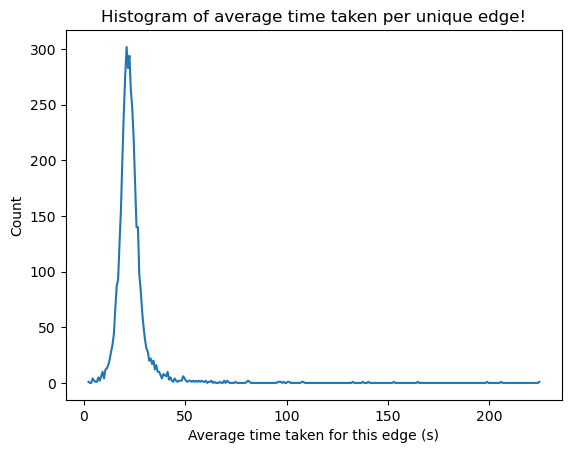

'Gaussianity' shaprio test p-value: 4.676840558622769e-33


In [31]:
paths_finished = pd.read_csv(PATHS_FINISHED, sep='\t', header=None, names=['hashedIpAddress', 'timestamp', 'durationInSec', 'path', 'rating'], encoding='utf-8', skiprows=16).copy(deep=True)
paths_finished["timestamp"] = pd.to_datetime(paths_finished["timestamp"], unit='s')

paths_and_time_fin = paths_finished[['durationInSec', 'path']].copy()
paths_and_time_fin['path_length'] = paths_and_time_fin['path'].apply(lambda x: len(x.split(';')))
paths_and_time_fin['coarse_mean_time'] = paths_and_time_fin['durationInSec'] / paths_and_time_fin['path_length']

display(paths_and_time_fin)

times_per_edge = defaultdict(list)

for idx, row in paths_and_time_fin.iterrows():
	elems_path = row['path'].split(';')
	for elem in elems_path:
		times_per_edge[elem].append(row['durationInSec'] / row['path_length'])

times_per_edge_micro = {key:np.mean(value) for key, value in times_per_edge.items()}

# p3 = sns.histplot(x = list(times_per_edge_micro.values()), bins=320)
np_hist = np.histogram(list(times_per_edge_micro.values()), bins=320)
p3 = sns.lineplot(x=np_hist[1][:-1], y=np_hist[0])
plt.xlabel('Average time taken for this edge (s)')
plt.ylabel('Count')
plt.title('Histogram of average time taken per unique edge!')
plt.show()

print("'Gaussianity' shaprio test p-value:", scipy.stats.shapiro(np_hist[0]).pvalue)

# Metric 9: BERTscore semantic similarity metric


100%|███████████████████████████████████████████████████████████████████████████| 51318/51318 [04:04<00:00, 209.90it/s]
C:\Users\mathi\anaconda3\envs\ada\lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\mathi\anaconda3\envs\ada\lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\mathi\AppData\Local\Temp\ipykernel_29108\2197508292.py:33: RuntimeWarning: Mean of empty slice
  'mean_rating':[np.nanmean(a[:, 0]) for a in global_dict.values()]


,edge,mean_bert_score,mean_rating
0,"(14th_century, 15th_century)",0.999987,2.600000
1,"(15th_century, 16th_century)",0.999637,2.428571
2,"(16th_century, Pacific_Ocean)",0.700767,NaN
3,"(Pacific_Ocean, Atlantic_Ocean)",0.990600,2.521739
4,"(Atlantic_Ocean, Accra)",0.098035,NaN
...,...,...,...
55142,"(Yagan, Folklore)",0.706183,3.000000
55143,"(A_Christmas_Carol, Novel)",0.582377,3.000000
55144,"(Yagan, Australia)",0.979503,NaN
55145,"(Yarralumla%2C_Australian_Capital_Territory, A...",0.842705,1.000000


C:\Users\mathi\AppData\Local\Temp\ipykernel_29108\2197508292.py:47: UserWarning: The figure layout has changed to tight
  p4.figure.tight_layout()


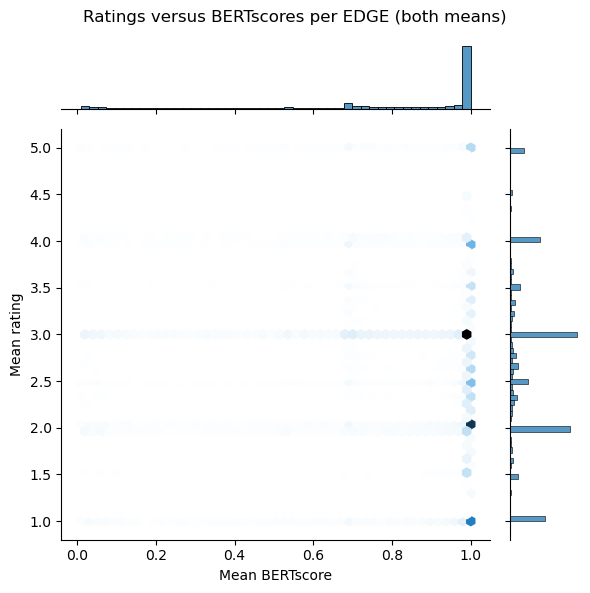

C:\Users\mathi\AppData\Local\Temp\ipykernel_29108\2197508292.py:61: UserWarning: The figure layout has changed to tight
  p6.figure.tight_layout()


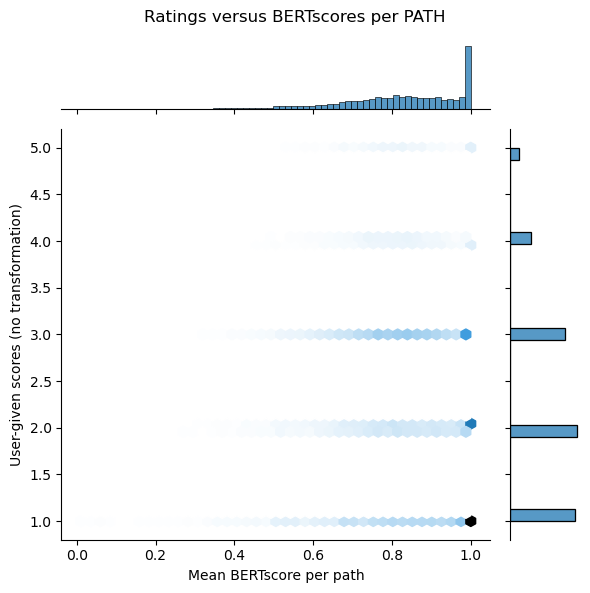

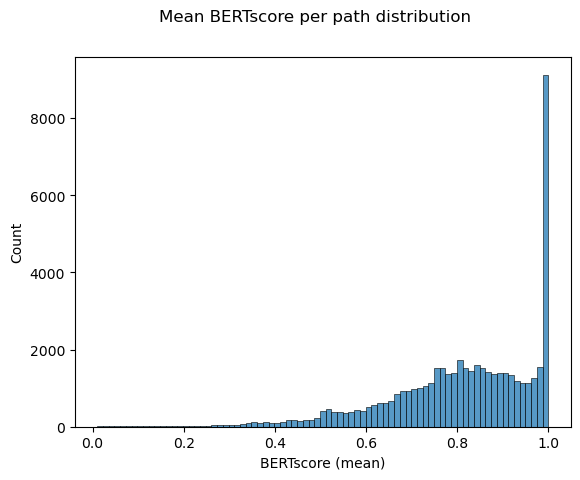

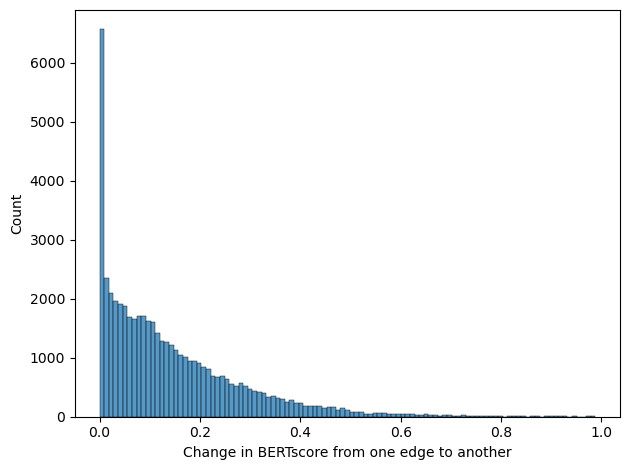

'Gaussianity' shaprio test p-value for mean BERTscore per EDGE's histogram: 1.9635877044604022e-19


In [32]:
tokenizer = AutoTokenizer.from_pretrained("dslim/bert-base-NER") # Named entity recognition-specific model!

def compute_sim(s1, s2):
	enc1 = tokenizer.encode(s1, return_tensors='pt').reshape(1, -1)
	enc2 = tokenizer.encode(s2, return_tensors='pt').reshape(1, -1)

	trunc = min(enc1.size(dim=1), enc2.size(dim=1))

	enc1 = enc1[:, :trunc]
	enc2 = enc2[:, :trunc]

	return cosine_similarity(enc1, enc2).squeeze().item()

sucessive_pairs = [[(x.split(';')[i], x.split(';')[i+1]) for i in range(len(x.split(';')) - 1)] for x in paths_finished['path'].to_list()]
sucessive_pairs_encoded = [[compute_sim(*a) for a in x] for x in tqdm(sucessive_pairs)]

sucessive_pairs_encoded_mean = np.array([np.mean(x) for x in sucessive_pairs_encoded]) # Mean BERTscore per path
aligned_finished_scores = paths_finished['rating'].to_numpy()[~np.isnan(sucessive_pairs_encoded_mean)] # This is for later
sucessive_pairs_encoded_mean = sucessive_pairs_encoded_mean[~np.isnan(sucessive_pairs_encoded_mean)] # Remove NaNs

from collections import defaultdict
global_dict = defaultdict(list)

for i in range(len(sucessive_pairs)):
	local_rating = paths_finished['rating'][i]
	for key, value in zip(sucessive_pairs[i], sucessive_pairs_encoded[i]):
		global_dict[key].append((local_rating, value))

global_dict = {key: np.array(value) for key, value in global_dict.items()}
edge_score_df = pd.DataFrame({
	'edge': global_dict.keys(),
	'mean_bert_score': [np.nanmean(a[:, 1]) for a in global_dict.values()],
	'mean_rating':[np.nanmean(a[:, 0]) for a in global_dict.values()]
})


display(edge_score_df)

p4 = sns.jointplot(data=edge_score_df,
			x='mean_bert_score',
			y='mean_rating',
			kind='hex',
)
p4.figure.suptitle('Ratings versus BERTscores per EDGE (both means)')
plt.xlabel('Mean BERTscore')
plt.ylabel('Mean rating')
p4.figure.tight_layout()
plt.show()

mean_BERT_and_score = pd.DataFrame({'successive_pairs_mean': sucessive_pairs_encoded_mean,
			  'finished_scores': aligned_finished_scores})

p6 = sns.jointplot(data=mean_BERT_and_score,
			  x='successive_pairs_mean',
			  y='finished_scores',
			  kind='hex'
)
p6.figure.suptitle('Ratings versus BERTscores per PATH')
plt.ylabel('User-given scores (no transformation)')
plt.xlabel('Mean BERTscore per path')
p6.figure.tight_layout()
plt.show()

# ------------------------------

p5 = sns.histplot(x=sucessive_pairs_encoded_mean)
p5.figure.suptitle('Mean BERTscore per path distribution')
plt.ylabel('Count')
plt.xlabel('BERTscore (mean)')
plt.show()

p7 = sns.histplot(x=np.abs(np.diff(sucessive_pairs_encoded_mean)))
p5.figure.suptitle('Incremental changes in pair semantic similarity')
plt.xlabel('Change in BERTscore from one edge to another')
plt.ylabel('Count')
p7.figure.tight_layout()
plt.show()

print("'Gaussianity' shaprio test p-value for mean BERTscore per EDGE's histogram:", scipy.stats.shapiro(np.histogram(edge_score_df['mean_bert_score'].to_numpy(), bins=80)[0]).pvalue)

This data seems relatively gaussian per path, and both the edge and path metrics have interesting distributions both on their own and when cross-compared. Our subsequent analysis should be interesting!